In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pylab as plt
from tqdm import tqdm
from scipy.stats import gaussian_kde

## Dataset generation

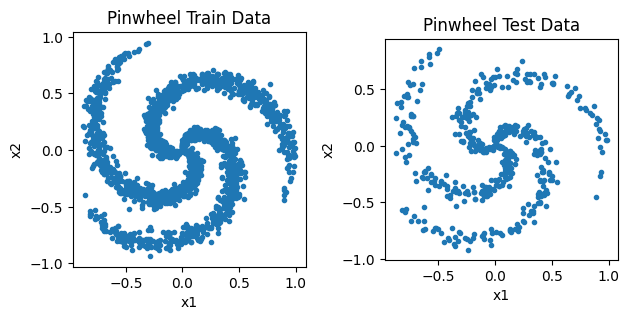

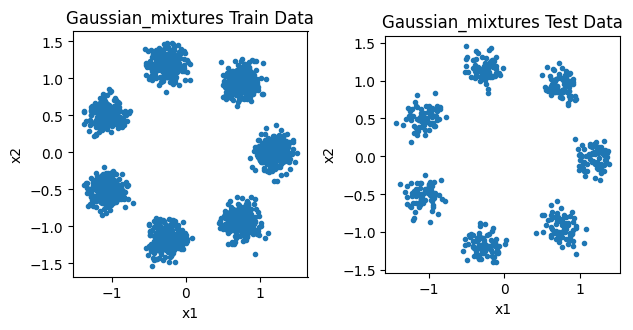

In [2]:
# X1 pinwheel, X2 gaussian_mixtures
X1_train, X1_test = np.load('Pinwheel_train.npy'), np.load('Pinwheel_test.npy')
X2_train, X2_test = np.load('Gaussian_Mixtures_train.npy'), np.load('Gaussian_Mixtures_test.npy')

fig1, ax1 = plt.subplots(1, 2)
ax1[0].plot(X1_train[:, 0], X1_train[:, 1], '.')
ax1[0].set_xlabel('x1')
ax1[0].set_ylabel('x2')
ax1[0].set_title('Pinwheel Train Data')
ax1[0].set_aspect('equal') 

ax1[1].plot(X1_test[:, 0], X1_test[:, 1], '.')
ax1[1].set_xlabel('x1')
ax1[1].set_ylabel('x2')
ax1[1].set_title('Pinwheel Test Data')
ax1[1].set_aspect('equal')

plt.tight_layout()
plt.show()

fig2, ax2 = plt.subplots(1, 2)
ax2[0].plot(X2_train[:, 0], X2_train[:, 1], '.')
ax2[0].set_xlabel('x1')
ax2[0].set_ylabel('x2')
ax2[0].set_title('Gaussian_mixtures Train Data')
ax2[0].set_aspect('equal') 

ax2[1].plot(X2_test[:, 0], X2_test[:, 1], '.')
ax2[1].set_xlabel('x1')
ax2[1].set_ylabel('x2')
ax2[1].set_title('Gaussian_mixtures Test Data')
ax2[1].set_aspect('equal')

plt.tight_layout()
plt.show()

In [3]:
class TimeEmbedding(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        self.embed_dim = embed_dim

    def forward(self, t):
        device = t.device
        half_dim = self.embed_dim // 2
        emb = np.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, dtype=torch.float32, device=device) * -emb)
        emb = t[:, None] * emb[None, :]
        return torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)

# define MLP network
class MLP(nn.Module):
    def __init__(self, input_dim, time_dim, hidden_dim, depth=4):
        """
        Args:
            input_dim: Dimension of input features (e.g., 2D input for Pinwheel).
            time_dim: Dimension of time embedding.
            hidden_dim: Dimension of the hidden layers.
            depth: Depth of the network (number of hidden layers).
        """
        super().__init__()
        self.time_embedding = TimeEmbedding(embed_dim=time_dim)

        # MLP structure
        layers = []
        layers.append(nn.Linear(input_dim + time_dim, hidden_dim))
        layers.append(nn.SiLU())  

        for _ in range(depth - 2):  
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.SiLU())

        layers.append(nn.Linear(hidden_dim, input_dim))  
        self.mlp = nn.Sequential(*layers)

    def forward(self, x_t, t):
        time_emb = self.time_embedding(t).to(x_t.device)  # time_step_embedding
        x = torch.cat([x_t, time_emb], dim=1)  # Concatenate data with time step embedding
        return self.mlp(x)

In [4]:
def forward_diffusion_sample(x_0, t, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod):
    """
    To sample data during the diffusion process at time step 𝑡, using sqrt_alpha和sqrt_one_minus_alpha
    """
    sqrt_alpha_t = sqrt_alphas_cumprod[t].unsqueeze(1)  # Add a dimension to match x_0
    sqrt_one_minus_alpha_t = sqrt_one_minus_alphas_cumprod[t].unsqueeze(1)  # Add a dimension to match epsilon
    
    epsilon = torch.randn_like(x_0)  # add noise
    x_t = sqrt_alpha_t * x_0 + sqrt_one_minus_alpha_t * epsilon
    return x_t, epsilon

## Testing

In [5]:
def test_ddpm(model, test_dataloader, betas):
    """
    Test the DDPM model.
    """
    mse_loss = nn.MSELoss()

    # Precompute and store these values
    sqrt_alphas_cumprod = torch.sqrt(torch.cumprod(1 - betas, dim=0))
    sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - torch.cumprod(1 - betas, dim=0))

    model.eval()  # Set the model to evaluation mode
    total_test_loss = 0

    with torch.no_grad():
        for batch in test_dataloader:
            x_0 = batch[0].to(device)
            t = torch.randint(0, len(betas), (x_0.size(0),), device=device)  # Random time step

            # Generate x_t using precomputed values
            x_t, epsilon = forward_diffusion_sample(
                x_0, t, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod
            )

            # Predict the noise
            epsilon_pred = model(x_t, t.float())
            loss = mse_loss(epsilon_pred, epsilon)  # Compute the loss

            total_test_loss += loss.item()

    # Calculate the average loss for the testing phase
    average_test_loss = total_test_loss / len(test_dataloader)
    
    return average_test_loss


## Training

In [6]:
def train_ddpm(model, train_dataloader, test_dataloader, betas, num_epochs=5, lr=1e-3):  
    """
    Train a DDPM (Denoising Diffusion Probabilistic Model) with integrated testing phase.
    """
    optimizer = optim.Adam(model.parameters(), lr=lr)  # Initialize the optimizer
    mse_loss = nn.MSELoss()  # Define the loss function (Mean Squared Error)

    # Precompute values for diffusion process
    sqrt_alphas_cumprod = torch.sqrt(torch.cumprod(1 - betas, dim=0))
    sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - torch.cumprod(1 - betas, dim=0))

    train_losses = []  # List to store training losses
    test_losses = []   # List to store testing losses

    for epoch in tqdm(range(num_epochs), desc='Training Progress', unit='epoch'):
        model.train()  # Set the model to training mode
        total_train_loss = 0

        # Iterate over the training data batches
        for batch in train_dataloader:
            x_0 = batch[0].to(device)  # Move input data to the appropriate device
            t = torch.randint(0, len(betas), (x_0.size(0),), device=device)  # Randomly select a time step for each sample

            # Generate x_t (noisy sample) using precomputed values
            x_t, epsilon = forward_diffusion_sample(
                x_0, t, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod
            )

            # The model predicts the noise added to x_t
            epsilon_pred = model(x_t, t.float())
            loss = mse_loss(epsilon_pred, epsilon)  # Compute the loss between predicted and actual noise

            # Backpropagation and optimization step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()  # Accumulate training loss

        # Calculate average training loss for the epoch
        average_train_loss = total_train_loss / len(train_dataloader)
        train_losses.append(average_train_loss)  # Store the average training loss

        # Call the test function after each epoch
        test_loss = test_ddpm(model, test_dataloader, betas)  # Test the model on the test dataset
        test_losses.append(test_loss)  # Store the average test loss

    return train_losses, test_losses  # Return both training and testing losses for further analysis


In [7]:
@torch.no_grad()
def sample_ddpm(model, betas, num_samples, device):
    """
    Progressively sample data from noise
    """
    T = len(betas)
    alphas = 1 - betas  # α_t
    alphas_cumprod = torch.cumprod(alphas, dim=0)  # Cumulative product ᾱ_t
    sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)  # √ᾱ_t
    sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - alphas_cumprod)  # √(1 - ᾱ_t)

    sqrt_alphas = torch.sqrt(alphas)  # √α_t

    # Start from a standard normal distribution
    x_t = torch.randn((num_samples, 2), device=device)
    for t in reversed(range(T)):
        z = torch.randn_like(x_t) if t > 0 else 0  # Do not add noise in the final iteration
        beta_t = betas[t]
        alpha_t = alphas[t]
        sqrt_alpha_t = sqrt_alphas[t]
        sqrt_one_minus_alpha_bar_t = sqrt_one_minus_alphas_cumprod[t]

        # Create a time step tensor that matches the batch size of x_t 
        t_tensor = torch.full((num_samples,), t, device=device).float()

        # denoise process
        epsilon_pred = model(x_t, t_tensor)
        x_t = (1 / sqrt_alpha_t) * (x_t - beta_t / sqrt_one_minus_alpha_bar_t * epsilon_pred) + torch.sqrt(beta_t) * z

    return x_t


## Results for Pinwheel

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data preparation
mean1 = np.mean(X1_train, axis=0)
std1 = np.std(X1_train, axis=0)
X1_train = (X1_train - mean1) / std1
pinwheel_data_train = torch.tensor(X1_train, dtype=torch.float32)

mean2 = np.mean(X1_test, axis=0)
std2 = np.std(X1_test, axis=0)
X1_test = (X1_test - mean2) / std2
pinwheel_data_test = torch.tensor(X1_test, dtype=torch.float32)

train_dataloader = DataLoader(TensorDataset(pinwheel_data_train), batch_size=64, shuffle=True)
test_dataloader = DataLoader(TensorDataset(pinwheel_data_test), batch_size=64, shuffle=False)


# paramaters
T = 500  # time step
betas = torch.linspace(0.0001, 0.02, T).to(device)  # Linear noise growth
model = MLP(input_dim=2, time_dim=32, hidden_dim=64, depth=4).to(device)

# train
losses, test_losses = train_ddpm(model, train_dataloader, test_dataloader, betas, num_epochs=2000, lr=1e-3)

Training Progress: 100%|████████████████████████████████████████████████████████| 2000/2000 [03:31<00:00,  9.47epoch/s]


In [9]:
def compute_ema(losses, alpha=0.01):
    ema_losses = [losses[0]]  
    for loss in losses[1:]:
        ema_current = alpha * loss + (1 - alpha) * ema_losses[-1]  
        ema_losses.append(ema_current)
    return np.array(ema_losses)

ema_losses = compute_ema(losses)
ema_test_losses = compute_ema(test_losses)

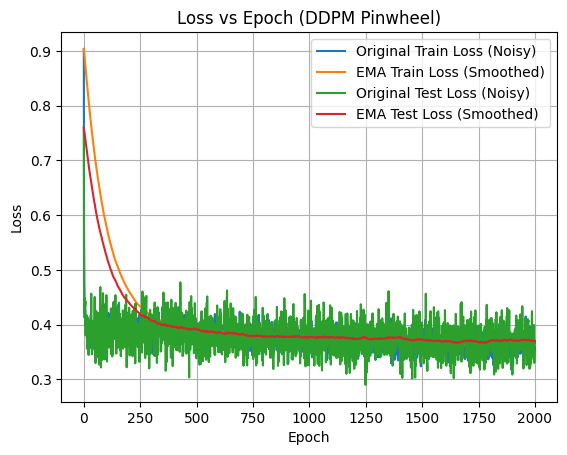

In [10]:
# Plot the original and EMA loss curves
plt.plot(losses, label="Original Train Loss (Noisy)")  # Original noisy loss curve
plt.plot(ema_losses, label="EMA Train Loss (Smoothed)")  # Smoothed EMA curve
plt.plot(test_losses, label="Original Test Loss (Noisy)")  # Original noisy loss curve
plt.plot(ema_test_losses, label="EMA Test Loss (Smoothed)")  # Smoothed EMA curve

# Add labels, title, and legend
plt.xlabel("Epoch")  # X-axis label
plt.ylabel("Loss")  # Y-axis label
plt.title("Loss vs Epoch (DDPM Pinwheel)")  # Title of the plot
plt.legend()  # Show the legend
plt.grid(True)  # Add a grid for better visualization

plt.savefig("DDPM_Loss_epoch_pinwheel.png", dpi=600) 

# Display the plot
plt.show()

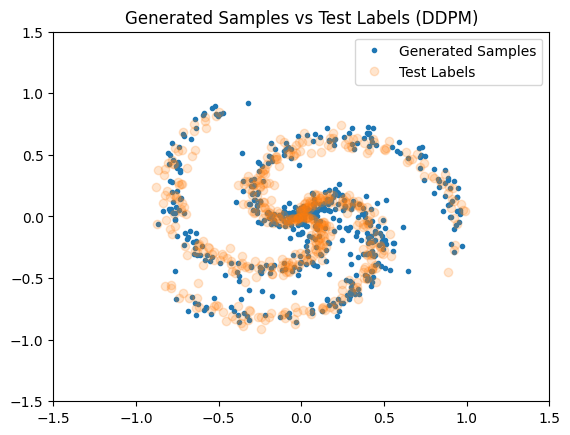

In [11]:
# Generation
samples = sample_ddpm(model, betas, num_samples=500, device=device)
samples = samples.cpu().numpy()
samples = samples * std1 + mean1

X1_test = X1_test * std2 + mean2

plt.plot(samples[:, 0], samples[:, 1], '.', label="Generated Samples")
plt.plot(X1_test[:, 0], X1_test[:, 1], 'o', alpha=0.2, label="Test Labels")

plt.xlim([-1.5, 1.5])
plt.ylim([-1.5, 1.5])
plt.title("Generated Samples vs Test Labels (DDPM)")
plt.legend()
plt.savefig("DDPM_samples_pinwheel.png", dpi=600) 
plt.show()

In [12]:
kde_generated = gaussian_kde(samples.T)
kde_real = gaussian_kde(X1_test.T)
log_likelihood_of_real_on_generated = kde_generated.logpdf(X1_test.T)
log_likelihood_of_generated_on_real = kde_real.logpdf(samples.T)
print('Sum of log-likelihood of generated data under the real data distribution:', np.sum(log_likelihood_of_real_on_generated))
print('Mean of log-likelihood of generated data under the real data distribution:', np.mean(log_likelihood_of_real_on_generated))
print('Sum of log-likelihood of generated data under the real data distribution:', np.sum(log_likelihood_of_generated_on_real))
print('Mean of log-likelihood of generated data under the real data distribution:', np.mean(log_likelihood_of_generated_on_real))

Sum of log-likelihood of generated data under the real data distribution: -396.2023389916936
Mean of log-likelihood of generated data under the real data distribution: -0.7924046779833872
Sum of log-likelihood of generated data under the real data distribution: -393.5768936909483
Mean of log-likelihood of generated data under the real data distribution: -0.7871537873818966


## Results for Gaussian Mixtures

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data preparation
mean1 = np.mean(X2_train, axis=0)
std1 = np.std(X2_train, axis=0)
X2_train = (X2_train - mean1) / std1
Gaussian_mixtures_data_train = torch.tensor(X2_train, dtype=torch.float32)

mean2 = np.mean(X2_test, axis=0)
std2 = np.std(X2_test, axis=0)
X2_test = (X2_test - mean2) / std2
Gaussian_mixtures_data_test = torch.tensor(X2_test, dtype=torch.float32)

train_dataloader = DataLoader(TensorDataset(Gaussian_mixtures_data_train), batch_size=64, shuffle=True)
test_dataloader = DataLoader(TensorDataset(Gaussian_mixtures_data_test), batch_size=64, shuffle=False)

# parameters
T = 500  # time step
betas = torch.linspace(0.0001, 0.02, T).to(device)  
model = MLP(input_dim=2, time_dim=32, hidden_dim=64, depth=4).to(device)

# train
losses, test_losses = train_ddpm(model, train_dataloader, test_dataloader, betas, num_epochs=2000, lr=1e-3)

Training Progress: 100%|████████████████████████████████████████████████████████| 2000/2000 [03:30<00:00,  9.50epoch/s]


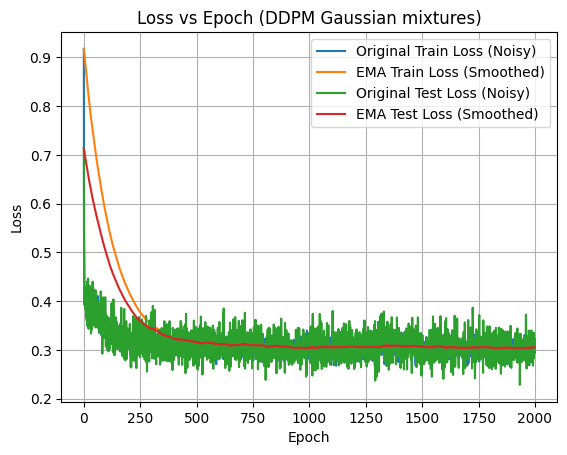

In [14]:
ema_losses = compute_ema(losses)
ema_test_losses = compute_ema(test_losses)

# Plot the original and EMA loss curves
plt.plot(losses, label="Original Train Loss (Noisy)")  # Original noisy loss curve
plt.plot(ema_losses, label="EMA Train Loss (Smoothed)")  # Smoothed EMA curve
plt.plot(test_losses, label="Original Test Loss (Noisy)")  # Original noisy loss curve
plt.plot(ema_test_losses, label="EMA Test Loss (Smoothed)")  # Smoothed EMA curve

# Add labels, title, and legend
plt.xlabel("Epoch")  # X-axis label
plt.ylabel("Loss")  # Y-axis label
plt.title("Loss vs Epoch (DDPM Gaussian mixtures)")  # Title of the plot
plt.legend()  # Show the legend
plt.grid(True)  # Add a grid for better visualization

plt.savefig("DDPM_Loss_epoch_gaussian_mixtures.png", dpi=600) 

# Display the plot
plt.show()

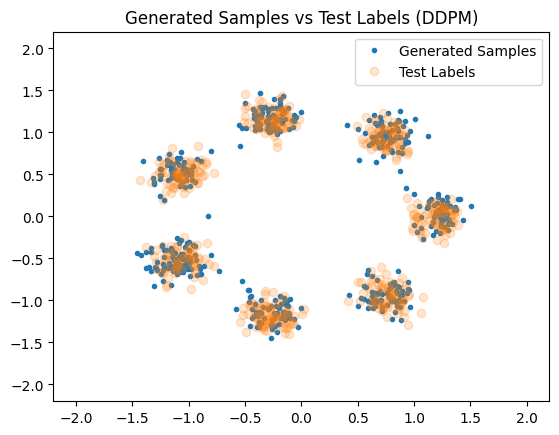

In [15]:
# Generation
samples = sample_ddpm(model, betas, num_samples=500, device=device)
samples = samples.cpu().numpy()
samples = samples * std1 + mean1

X2_test = X2_test * std2 + mean2

plt.plot(samples[:, 0], samples[:, 1], '.', label="Generated Samples")
plt.plot(X2_test[:, 0], X2_test[:, 1], 'o', alpha=0.2, label="Test Labels")

plt.xlim([-2.2, 2.2])
plt.ylim([-2.2, 2.2])
plt.title("Generated Samples vs Test Labels (DDPM)")
plt.legend()
plt.savefig("DDPM_samples_gaussian_mixtures.png", dpi=600) 
plt.show()

In [16]:
kde_generated = gaussian_kde(samples.T)
kde_real = gaussian_kde(X2_test.T)
log_likelihood_of_real_on_generated = kde_generated.logpdf(X2_test.T)
log_likelihood_of_generated_on_real = kde_real.logpdf(samples.T)
print('Sum of log-likelihood of generated data under the real data distribution:', np.sum(log_likelihood_of_real_on_generated))
print('Mean of log-likelihood of generated data under the real data distribution:', np.mean(log_likelihood_of_real_on_generated))
print('Sum of log-likelihood of generated data under the real data distribution:', np.sum(log_likelihood_of_generated_on_real))
print('Mean of log-likelihood of generated data under the real data distribution:', np.mean(log_likelihood_of_generated_on_real))

Sum of log-likelihood of generated data under the real data distribution: -854.6541999624638
Mean of log-likelihood of generated data under the real data distribution: -1.7093083999249277
Sum of log-likelihood of generated data under the real data distribution: -844.4431691576764
Mean of log-likelihood of generated data under the real data distribution: -1.6888863383153527
